Image segmentation
==================

In this notebook we illustrate how to use the script `scripts/image_parsing/main_raw_to_clips.py` to segment (i.e. extract) clips containing a single organisms from large-pane images containing multiple organisms. 

As a first, step, import the necessary packages, including the custom functions of this repository `msbsuite.utils` (if you have trouble importing this package, refer back to the `Installation` section of the documentation). 

In [24]:
import argparse
import sys
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import yaml
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import feature, measure, morphology, segmentation
from tqdm import tqdm

from mzbsuite.utils import cfg_to_arguments

We now need to declare the parameters to tell the script where to find the files and where to save its outputs. In this notebook, we pass these arguments as a dictionary to Python, rather than variables in a shell (`.sh`) script. 

You need to have downloaded the example dataset in order for this cell to compile properly. Alternatively you can change the file paths to the locations of folders of your own dataset on the `arguments = {}` block; the path is relative to where this notebook is located. 

In [25]:
ROOT_DIR = Path("D:\mzb-workflow") #Path("/data/shared/mzb-workflow")

arguments = {
    "input_dir": ROOT_DIR / "data/mzb_example_data/raw_img/", 
    "output_dir": ROOT_DIR / "data/derived/mzb_example_data/", 
    "save_full_mask_dir": ROOT_DIR / "data/derived/mzb_example_data/full_image_masks/", 
    "config_file": ROOT_DIR / "configs/mzb_example_config.yaml", 
}
    
with open(str(arguments["config_file"]), "r") as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

cfg["trcl_gpu_ids"] = None # this sets the number of available GPUs to zero, since this script doesn't benefit from GPU compute. 
cfg

{'glob_random_seed': 222,
 'glob_root_folder': '/home/jovyan/work/mzb-workflow/',
 'glob_blobs_folder': '/home/jovyan/work/mzb-workflow/data/derived/blobs/',
 'glob_local_format': 'pdf',
 'model_logger': 'wandb',
 'impa_image_format': 'jpg',
 'impa_clip_areas': [2700, 4700, -1, -1],
 'impa_area_threshold': 5000,
 'impa_gaussian_blur': [21, 21],
 'impa_gaussian_blur_passes': 3,
 'impa_adaptive_threshold_block_size': 351,
 'impa_mask_postprocess_kernel': [11, 11],
 'impa_mask_postprocess_passes': 5,
 'impa_bounding_box_buffer': 200,
 'impa_save_clips_plus_features': True,
 'lset_class_cut': 'order',
 'lset_val_size': 0.1,
 'trcl_learning_rate': 0.0001,
 'trcl_batch_size': 8,
 'trcl_weight_decay': 0,
 'trcl_step_size_decay': 5,
 'trcl_number_epochs': 75,
 'trcl_save_topk': 1,
 'trcl_num_classes': 8,
 'trcl_model_pretrarch': 'convnext-small',
 'trcl_num_workers': 16,
 'trcl_wandb_project_name': 'mzb-classifiers',
 'trcl_logger': 'wandb',
 'trsk_learning_rate': 0.001,
 'trsk_batch_size': 32

The `cfg` variable should display a portion of the list of parameters in the configuration file. 

Now we use custom function `cfg_to_arguments` to parse the parameters we have just supplied and the parameters in the configuration file: 

In [26]:
args = cfg_to_arguments(arguments)
cfg = cfg_to_arguments(cfg)
print(str(cfg))

{'glob_random_seed': 222, 'glob_root_folder': '/home/jovyan/work/mzb-workflow/', 'glob_blobs_folder': '/home/jovyan/work/mzb-workflow/data/derived/blobs/', 'glob_local_format': 'pdf', 'model_logger': 'wandb', 'impa_image_format': 'jpg', 'impa_clip_areas': [2700, 4700, -1, -1], 'impa_area_threshold': 5000, 'impa_gaussian_blur': [21, 21], 'impa_gaussian_blur_passes': 3, 'impa_adaptive_threshold_block_size': 351, 'impa_mask_postprocess_kernel': [11, 11], 'impa_mask_postprocess_passes': 5, 'impa_bounding_box_buffer': 200, 'impa_save_clips_plus_features': True, 'lset_class_cut': 'order', 'lset_val_size': 0.1, 'trcl_learning_rate': 0.0001, 'trcl_batch_size': 8, 'trcl_weight_decay': 0, 'trcl_step_size_decay': 5, 'trcl_number_epochs': 75, 'trcl_save_topk': 1, 'trcl_num_classes': 8, 'trcl_model_pretrarch': 'convnext-small', 'trcl_num_workers': 16, 'trcl_wandb_project_name': 'mzb-classifiers', 'trcl_logger': 'wandb', 'trsk_learning_rate': 0.001, 'trsk_batch_size': 32, 'trsk_weight_decay': 0, 'tr

Now we check whether the output directories already exist, and if not create them. 

In [27]:
# define paths
main_root = Path(args.input_dir)
outdir = Path(args.output_dir)
outdir.mkdir(parents=True, exist_ok=True)

if args.save_full_mask_dir is not None:
        args.save_full_mask_dir = Path(args.save_full_mask_dir)

Parse the contents of the input folder and standardise filenames, and print how many images are going to be processed. 

In [28]:
# get list of files to process
files_proc = list(main_root.glob(f"**/*.{cfg.impa_image_format}"))
# # make sure weird capitalization doesn't cause issues
# files_proc.extend(list(main_root.glob(f"**/*.{cfg.impa_image_format.upper()}")))
files_proc = [a for a in files_proc if "mask" not in str(a)]
files_proc.sort()

print(f"Parsing {len(files_proc)} files")

Parsing 2 files


If a clip area is defined, for instance if there is a reference scale in the same spot in all the images, this area is earmarked for exclusion in later processing. 

In [29]:
if cfg.impa_clip_areas is not None:
    location_cutout = [int(a) for a in cfg.impa_clip_areas]

If the `PLOTS` variable is True, then the script will print out a summary plot for each image and for each individual clip being generated. If you don't want plots being generated, change the value to False. If you would like to save each plot as a file, you can uncomment (i.e. remove `# `) the lines `plt.savefig()` in the loop below. 

> ⚠️ WARNING: this can be computationally intensive and can potentially crash the notebook if a large number number of outputs is generated! 

In [30]:
from IPython.display import display, clear_output
PLOTS = True

Define a normalisation function to flatten the pixel values of images (this helps with downstream processing). 

In [31]:
# define quick normalization function
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

Below is the main loop that processes the images into clips, and will also produce figures if `PLOTS = True`. If `PLOTS = False`, the script will save a `.csv` file with information about each image and clips generated from it, as well as other information such as bounding box coordinates, pixel areas of the mask, etc. 

For further details about the logic fo this script please refer to the explanation in the section `Segmentation` under `Processing scripts` in the documentation. 

> ⚠️ WARNING: depending on the number of images and how many organisms are present, the processing time of the loop can be considerable. 

In [ ]:
iterator = tqdm(files_proc, total=len(files_proc))
for i, fo in enumerate(iterator):
    
    mask_props = []

    # get image path
    raw_image_in = fo
    full_path_raw_image_in = fo.resolve()

    # read image and convert to HSV
    img = cv2.imread(str(full_path_raw_image_in))[:, :, [2, 1, 0]]

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    im_t = hsv[:, :, 0].copy()
    im_t = (255 * norm(np.mean(hsv[:, :, :2], axis=2))).astype(np.uint8)

    # filter image with some iterations of gaussian blur
    for _ in range(cfg.impa_gaussian_blur_passes):
        im_t = cv2.GaussianBlur(im_t, tuple(cfg.impa_gaussian_blur), 0)

    # prepare for morphological reconstruction
    seed = np.copy(im_t)
    seed[1:-1, 1:-1] = im_t.min()
    mask = np.copy(im_t)

    # remove the background
    dil = morphology.reconstruction(seed, im_t, method="dilation")
    im_t = (im_t - dil).astype(np.uint8)

    # adaptive local thresholding of foreground vs background
    # weighted cross correlation with gaussian filter
    ad_thresh = cv2.adaptiveThreshold(
        im_t,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        cfg.impa_adaptive_threshold_block_size,
        -2,
    )
    # additional global threhsold to remove foreground vs background
    t, thresh = cv2.threshold(im_t, 0, 255, cv2.THRESH_OTSU)

    # merge thresholds to globally get foreground masks
    # thresh = thresh | ad_thresh
    thresh = thresh + ad_thresh > 0

    # postprocess masking to remove small objects and fill holes
    kernel = np.ones(cfg.impa_mask_postprocess_kernel, np.uint8)
    for _ in range(cfg.impa_mask_postprocess_passes):
        thresh = cv2.morphologyEx(
            (255 * thresh).astype(np.uint8), cv2.MORPH_CLOSE, kernel
        )
        thresh = cv2.morphologyEx(
            (255 * thresh).astype(np.uint8), cv2.MORPH_OPEN, kernel
        )
    thresh = ndimage.binary_fill_holes(thresh)

    # cut out area related to measurement/color calibration widget
    if cfg.impa_clip_areas is not None:
        thresh[
            location_cutout[0] : location_cutout[2],
            location_cutout[1] : location_cutout[3],
        ] = 0

    # get labels of connected components
    labels = measure.label(thresh, connectivity=2, background=0)

    if PLOTS: 
        full_image_thresh_fig, full_image_thresh_ax = plt.subplots(1, 4, figsize=(21, 9))
        full_image_thresh_ax[0].imshow(thresh)
        full_image_thresh_ax[0].title.set_text('global threshold')
        full_image_thresh_ax[1].imshow(ad_thresh)
        full_image_thresh_ax[1].title.set_text('adaptive threshold')
        full_image_thresh_ax[2].imshow(img)
        full_image_thresh_ax[2].title.set_text('original rgb')
        full_image_thresh_ax[3].imshow(labels)
        full_image_thresh_ax[3].title.set_text('labels')
        plt.show()              
        # plt.savefig("test.png")

    # Save the labels as a jpg for the full image
    if args.save_full_mask_dir is not None:
        args.save_full_mask_dir.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(
            str(args.save_full_mask_dir / f"labels_{fo.stem}.jpg").lower(),
            (labels).astype(np.uint8),
        )
        if not cfg.impa_save_clips_plus_features:
            if args.verbose:
                print("skipping clip generation")
            continue

    # get region properties
    rprop = measure.regionprops(labels)
    mask = np.ones(thresh.shape, dtype="uint8")

    # init some stuff
    sub_df = pd.DataFrame([])
    c = 1
    # loop through identified regions and get some properties
    for label in range(len(rprop)):  # np.unique(labels):
        
        clear_output(wait=True)
        
        reg_pro = rprop[label]

        # skip background
        if reg_pro.label == 0:
            continue

        # skip small objects
        if reg_pro.area < cfg.impa_area_threshold:  # 5000 defauilt
            continue

        # get mask for current region of interest
        current_mask = np.zeros(thresh.shape)
        current_mask[labels == reg_pro.label] = 1

        # coordinates of bounding box corners for current region of interest
        (
            min_row,
            min_col,
            max_row,
            max_col,
        ) = reg_pro.bbox  # cv2.boundingRect(approx)
        (x, y, w, h) = (min_col, min_row, max_col - min_col, max_row - min_row)

        # get the bounding box with some buffer
        (x_e, y_e, w_e, h_e) = (
            np.max((x - cfg.impa_bounding_box_buffer, 0)),
            np.max((y - cfg.impa_bounding_box_buffer, 0)),
            w + 2 * cfg.impa_bounding_box_buffer,
            h + 2 * cfg.impa_bounding_box_buffer,
        )

        if PLOTS:            
            clip_crop_fig, clip_crop_ax = plt.subplots(1, 1, figsize=(10, 6))
            clip_crop_ax.imshow(img[:, :, [0, 1, 2]], aspect="auto")
            rect = plt.Rectangle(
                (x_e, y_e), w_e, h_e, fc="none", ec="black", linewidth=2
            )
            clip_crop_ax.add_patch(rect)
            
            # clear_output(wait = True)
            display(full_image_thresh_fig)
            
            plt.show()
            # plt.savefig(f"test_mask{c}.png")
            # exit()

        # get the crop of the image and the mask
        crop = img[y_e : y_e + h_e, x_e : x_e + w_e, [2, 1, 0]]
        crop_hsv = hsv[y_e : y_e + h_e, x_e : x_e + w_e, :]
        crop_mask = current_mask[y_e : y_e + h_e, x_e : x_e + w_e]
        crop_im_t = im_t[y_e : y_e + h_e, x_e : x_e + w_e]

        im_crop_m = crop.reshape(-1, 3)[
            crop_mask.reshape(
                -1,
            ).astype(bool),
            :,
        ]
        hsv_crop_m = crop_hsv.reshape(-1, 3)[
            crop_mask.reshape(
                -1,
            ).astype(bool),
            :,
        ]

        # save actual image and mask crops
        # Avoid "invalid value encountered in true_divide" warning
        np.seterr(divide="ignore", invalid="ignore")
        cv2.imwrite(
            str(outdir / (f"{fo.stem}_{c}_mask.{cfg.impa_image_format}").lower()),
            (255 * crop_mask / crop_mask).astype(np.uint8),
            [cv2.IMWRITE_JPEG_QUALITY, 100],
        )

        # reactivate warnings
        np.seterr(divide="warn", invalid="warn")

        cv2.imwrite(
            str(outdir / (f"{fo.stem}_{c}_rgb.{cfg.impa_image_format}").lower()),
            crop,
            [cv2.IMWRITE_JPEG_QUALITY, 100],
        )
        # get average color of the crop
        # not really needed, aren't they
        # im_crop_cmean = str(np.mean(im_crop_m, axis=0))
        # hsv_crop_cmean = str(np.mean(hsv_crop_m, axis=0))

        # im_crop_std = str(np.std(im_crop_m, axis=0))
        # hsv_crop_std = str(np.std(hsv_crop_m, axis=0))

        mask = mask + current_mask * c

        if PLOTS:
            clip_fig, clip_ax = plt.subplots(1, 4, figsize=(10, 6))
            clip_ax[0].imshow(crop)
            clip_ax[0].title.set_text('crop')
            clip_ax[1].imshow(reg_pro.image)  # crop_mask)
            clip_ax[1].title.set_text('binary mask')
            clip_ax[2].imshow(
                (
                    crop * np.transpose(np.tile(crop_mask, (3, 1, 1)), (1, 2, 0))
                ).astype(np.uint8)
            )
            clip_ax[2].title.set_text('mask HSV')
            im_t_crop_m = crop_im_t.reshape(-1, 1)[
                crop_mask.reshape(
                    -1,
                ).astype(bool),
                :,
            ]
            clip_ax[3].hist(im_t_crop_m, bins=50)
            clip_ax[3].title.set_text('colour histogram')
            # plt.pause(1)
            plt.show()                 

        sub_df = {}
        sub_df["input_file"] = raw_image_in
        sub_df["species"] = raw_image_in.name.split(".")[0]
        sub_df["png_mask_id"] = c
        sub_df["reg_lab"] = reg_pro.label
        sub_df["squareness"] = w / float(h)
        # sub_df["average_color"] = im_crop_cmean
        # sub_df["average_color_std"] = im_crop_std
        # sub_df["average_hsv"] = hsv_crop_cmean
        # sub_df["average_hsv_std"] = hsv_crop_std
        sub_df["tight_bb"] = f"({x}, {y}, {w}, {h})"
        sub_df["large_bb"] = f"({x_e}, {y_e}, {w_e}, {h_e})"
        sub_df["ell_minor_axis"] = reg_pro.minor_axis_length
        sub_df["ell_major_axis"] = reg_pro.major_axis_length
        sub_df["bbox_area"] = reg_pro.bbox_area
        sub_df["area_px"] = reg_pro.area
        sub_df["mask_centroid"] = str(reg_pro.centroid)
        sub_df = pd.DataFrame(data=sub_df, index=[0])

        mask_props.append(sub_df)
        c += 1
        
if not PLOTS:
    if mask_props:
        mask_props = pd.concat(mask_props).reset_index().drop(columns=["index"])
        mask_props.to_csv(outdir / "_mask_properties.csv")

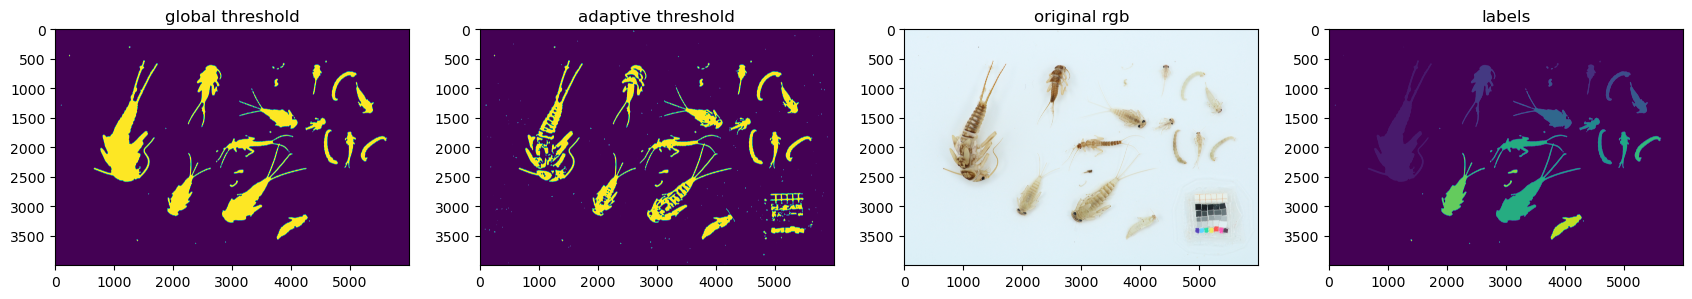

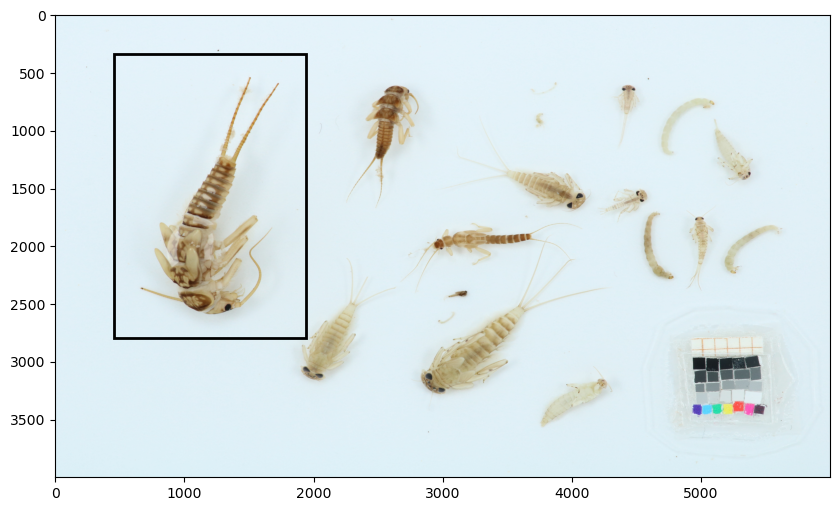

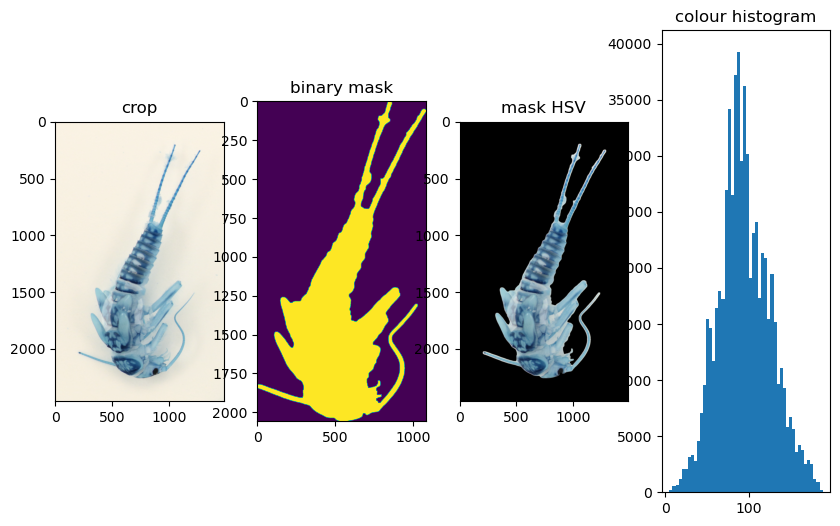